# Quantum algorithm for finding minimum values in a quantum random access memory

**Authors: Anton S. Albino, Lucas Q. Galvão, Mauro Q. Nooblath Neto, Ethan Hansen and Clebson Cruz**

We describe the implementation of the QMS algorithm using the IBM Quantum Experience framework open source called Quantum Information Software Development Kit – Qiskit. It allows users to manipulate and simulate quantum information and run algorithms on real quantum computers available in the IBM cloud. The framework is widely used by the scientific community in the development of quantum computing projects as it helps in the development and visualization of quantum circuits, along with result analysis using tools such as the Bloch Sphere and histograms. 

Before starting to implement the algorithm, it is necessary to import all the necessary libraries to compile the algorithm correctly. This can be seen in the box below:

In [1]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit import *
from qiskit_aer import *
import numpy as np
import random
from random import choice
from qiskit.visualization import *

backend = Aer.get_backend('qasm_simulator')

As discussed, the circuit is constructed by defining the register $n$, $m$, and $ancilla$ qubits. The $n$ and $m$ variables are the first and second registers of the QRAM, respectively; the $ancilla$ is the auxiliary register used in the $P$ operator. Here, we introduce the data set $Y$ that will be stored in the QRAM. 

In [2]:
n = 3
m = 4
aux = 1

Y = [[0,1,0,1], [0,1,0,0], [1,1,0,0], [1,0,1,0], [1,0,0,0]]

total = n+m+aux

qn = QuantumRegister(n, 'qn')
qm = QuantumRegister(m, 'qm')
q_aux = QuantumRegister(aux, 'aux')
c = ClassicalRegister(n, 'c')
qc = QuantumCircuit(qn, qm, q_aux, c)

The next step is to create and store the data set in the QRAM. For this purpose, it is necessary to construct the $U_x$ operator, corresponding to the function $qram()$ in the code described in Box 3. It applies a controlled-NOT gate with all-zero control qubits: the procedure $gate\_x()$ incorporates a quantum NOT gate both preceding and succeeding the control register ($n$) of the Toffoli Gate, which constitutes the first register in the QRAM ($n$). the Toffoli target qubits, which are the second register of the QRAM ($m$), correspond to the data set values in the QRAM ($Y$).

In [4]:
def qram(qc, qn):
    
    #Aplicação da CNOT 
    for d in range(len(Y)):
        gate_x(qc,qn, d)
        for i in range(m):
            if(Y[d][i]==1):
                qc.mcx(qn,n+i)
        gate_x(qc,qn, d)
        qc.barrier()

And the routine $gate\_x()$ code can be seen below:

In [3]:
def gate_x(qc, qn, decimal):
        binary_representation = bin(decimal)[2:].zfill(n)
        binary_list = [int(bit) for bit in binary_representation]
        for l in range(n):
            if (binary_list[l] == 0):
                qc.x(qn[l])

Another operator used in the QMS algorithm is the diffuser, an important part of Grover's Algorithm \cite{grover1996fast}. It is a quantum operation that amplifies the probability of the desired solution. It acts as a reflection around the average of amplitudes, increasing the probability of the correct answer and facilitating convergence to the solution during algorithm iterations \cite{koch2020fundamentals} ({see Definition \ref{def:2}}). Its coding can be visualized below: 

In [5]:
def diffuser(qc, qn):
    qc.h(range(n))
    qc.x(range(n))
    qc.h(n-1)
    qc.mcx(qn[:-1],n-1)
    qc.h(n-1)
    qc.x(range(n))
    qc.h(range(n))
    qc.barrier()
    

At this point, we need to define variables sufficient to optimize the search (Box 6). For this purpose, it is required a cost list for performing $P$ operator optimization in order to choose a random value ($current\_min$) to give its structure: the register in which the NOT Gate will be applied ($control2$) and the Tofolli controlled register ($control$). 

In [6]:
cost_list = [5,4,12,10,8]
current_min = np.random.choice(cost_list)
pos = cost_list.index(current_min)
control=[]
control2=[]
count = []
curr_min = []

The initial values of the $control$ and $control2$ can be obtained using the code below:

In [7]:
for i in range(m):
    if(Y[pos][i]==0):
        control.append(i+n)
        control2.append(i+n)
    if(Y[pos][i]==1):
        control.append(i+n)
        control2.append(i+n)
        break



Finally, we can compile the code with all routines defined. As discussed previously, it is necessary to initialize all $n-registers$ using a Hadamard gate. An important point in the algorithm is to initialize the ancilla register in the state $\ket{-}$ in order to make $P$ operator apply a negative phase in the desired state.


In [9]:
for i in range(m):
    # INITIALIZE
    qc.h(qn)
    qc.x(total-1)
    qc.h(total-1)
    qc.barrier()
    # END INITIALIZE
    
    #  ################### GROVER ITERATION ##########################
    
    # STORES cost_list in qm
    qram(qc, qn)
    # END STORAGE
    
    # FLIP PHASE
    qc.x(control2)
    qc.mcx(control,total-1)
    qc.x(control2)
    qc.barrier()
    # END FLIP PHASE
    
    # UNCOMPUTE qRAM
    qram(qc, qn)
    # END UNCOMPUTE
    
    # DIFFUSER
    diffuser(qc,qn)
    # END DIFFUSER
    
    # CHANGE ORDER OF QUBITS
    qc.swap(0,n-1)
    
    # MEASUREMENT
    qc.measure(range(n),range(n))
        
    # EXECUTE
    pm = generate_preset_pass_manager(optimization_level=0, backend=backend)
    
    transpile = pm.run(qc)
    
    counts = backend.run(transpile, shots=1).result().get_counts()
    
    #counts = execute(qc, backend=simulator, shots=1).result().get_counts(qc)
    
    # BINARY TO DECIMAL
    for measured_value in counts:
        a= min(int(measured_value, 2), len(Y)-1)
    
    print(control,control2)
    print('index=', a)
    print('current min=', cost_list[a])
    
    # OPTIMIZATION
    if((cost_list[a]<current_min) and (len(count)==0)):
        current_min = cost_list[a]        
        control.append(len(control)+n)
        control2.append(len(control2)+n)
        
    elif(cost_list[a]>=current_min):
        count.append(0)        
        control.append(len(control)+n)
        
        if(len(count)==1):
            control2[len(control2)-1]=control2[len(control2)-1]+1
        else:
            control2.append(control2[len(control2)-1]+1)
    if(control[len(control)-1]==6):
        print(control,control2)
        print('index=', a)
        print('current min=', cost_list[a])
        break
        
    curr_min.append(cost_list[a])

[3] [3]
index= 0
current min= 5
[3, 4] [3, 4]
index= 4
current min= 8
[3, 4, 5] [3, 5]
index= 3
current min= 10
[3, 4, 5, 6] [3, 5, 6]
index= 3
current min= 10


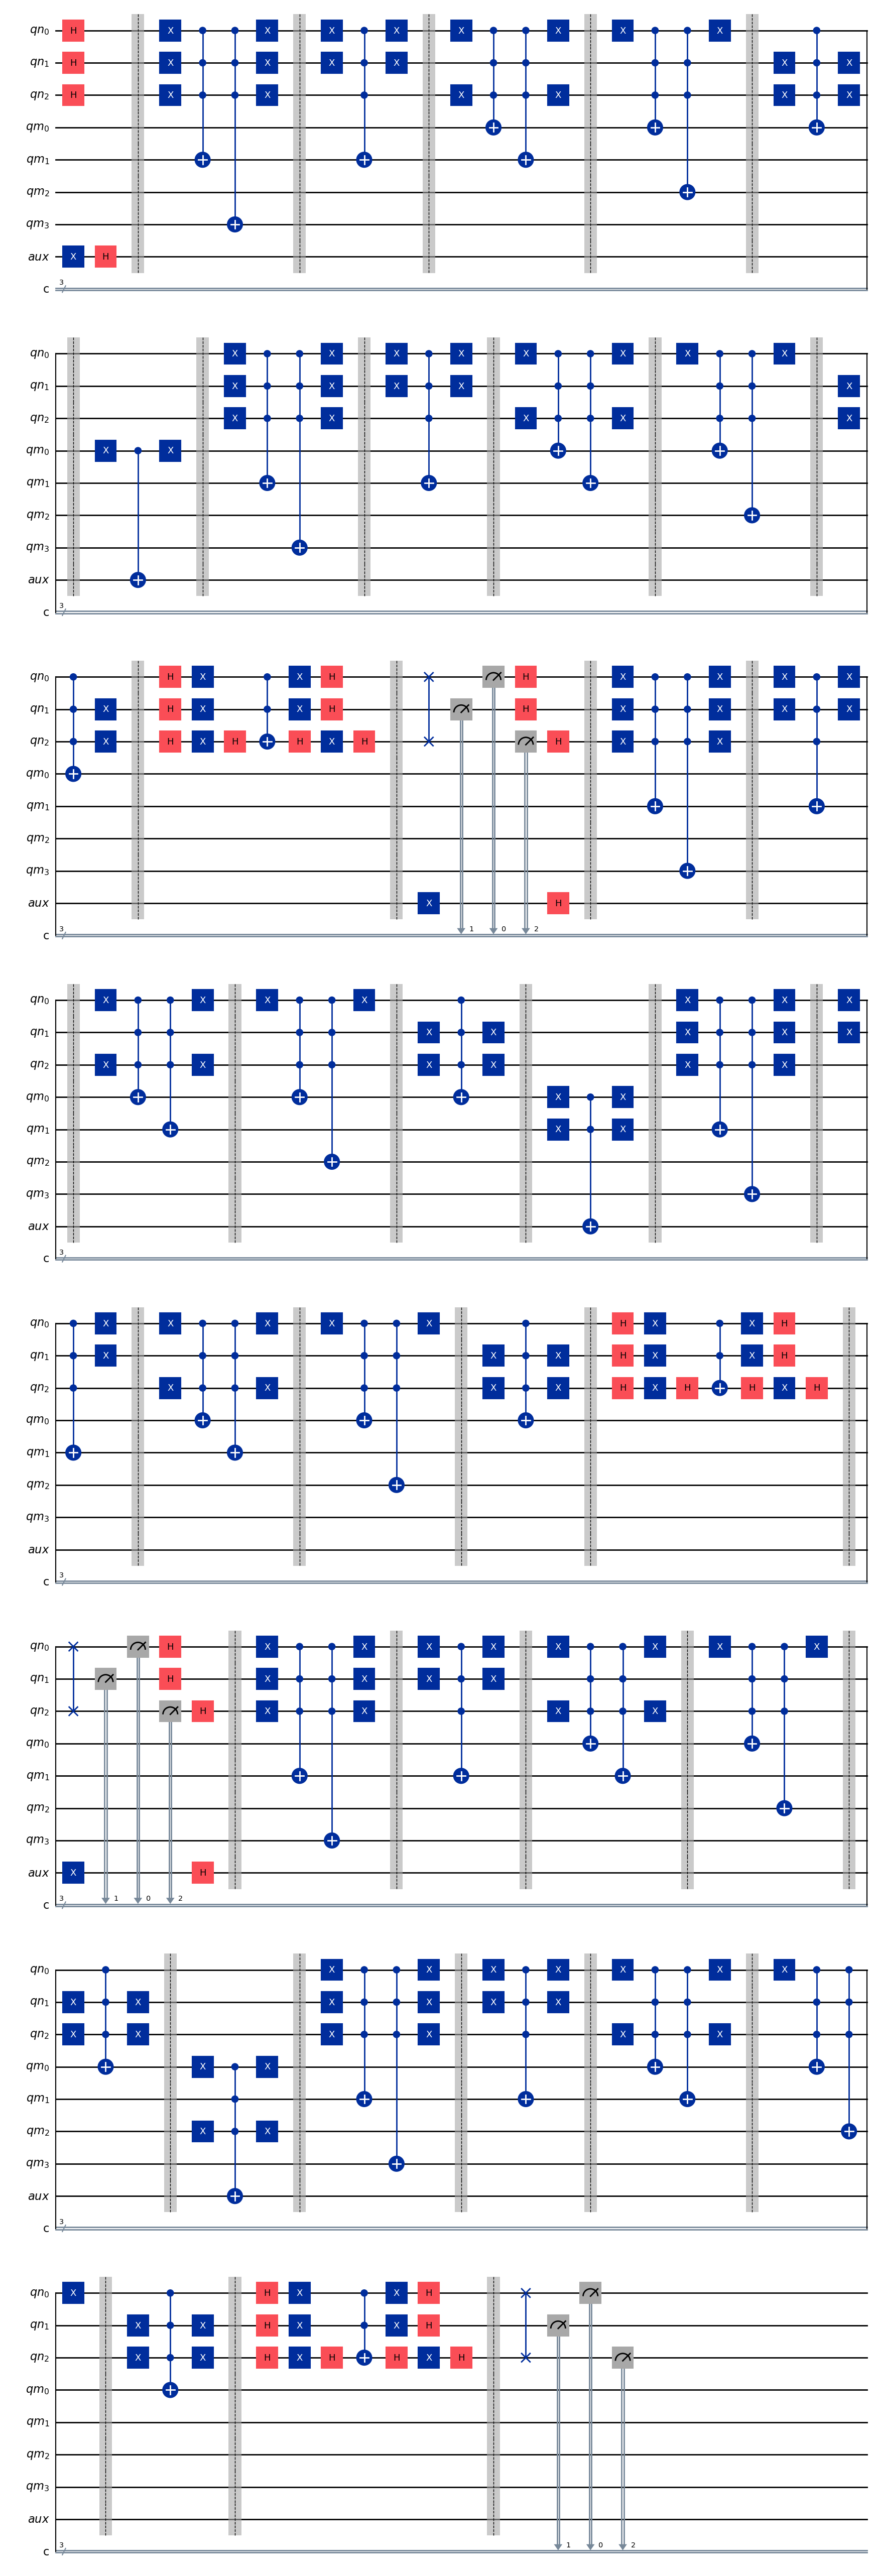

In [10]:
qc.draw(output = 'mpl')

Now we can check if the $\mathbf P$ dynamics was implemented sucessfuly using the code below:

In [13]:
QSM = QuantumCircuit(qn, qm, q_aux, c)

# INITIALIZE
QSM.h(qn)
QSM.x(total-1)
QSM.h(total-1)
QSM.barrier()
# END INITIALIZE

################### FIRST GROVER ITERATION ##########################

# Stores Qram
qram(QSM, qn)
# END STORAGE


# FLIP PHASE
QSM.x(control2)
QSM.mcx(control,total-1)
QSM.x(control2)
QSM.barrier()
# END FLIP PHASE


# UNCOMPUTE qRAM
qram(QSM, qn)
# END UNCOMPUTE


# DIFFUSER
diffuser(QSM,qn)
# END DIFFUSER


# CHANGE ORDER OF QUBITS
QSM.swap(0,n-1)


# MEASUREMENT
QSM.measure(range(n),range(n))

# EXECUTE
pm = generate_preset_pass_manager(optimization_level=0, backend=backend)

transpile = pm.run(QSM)

counts = backend.run(transpile, shots=1000).result().get_counts() 

#counts = execute(QSM, backend=simulator, shots=1000).result().get_counts(QSM)

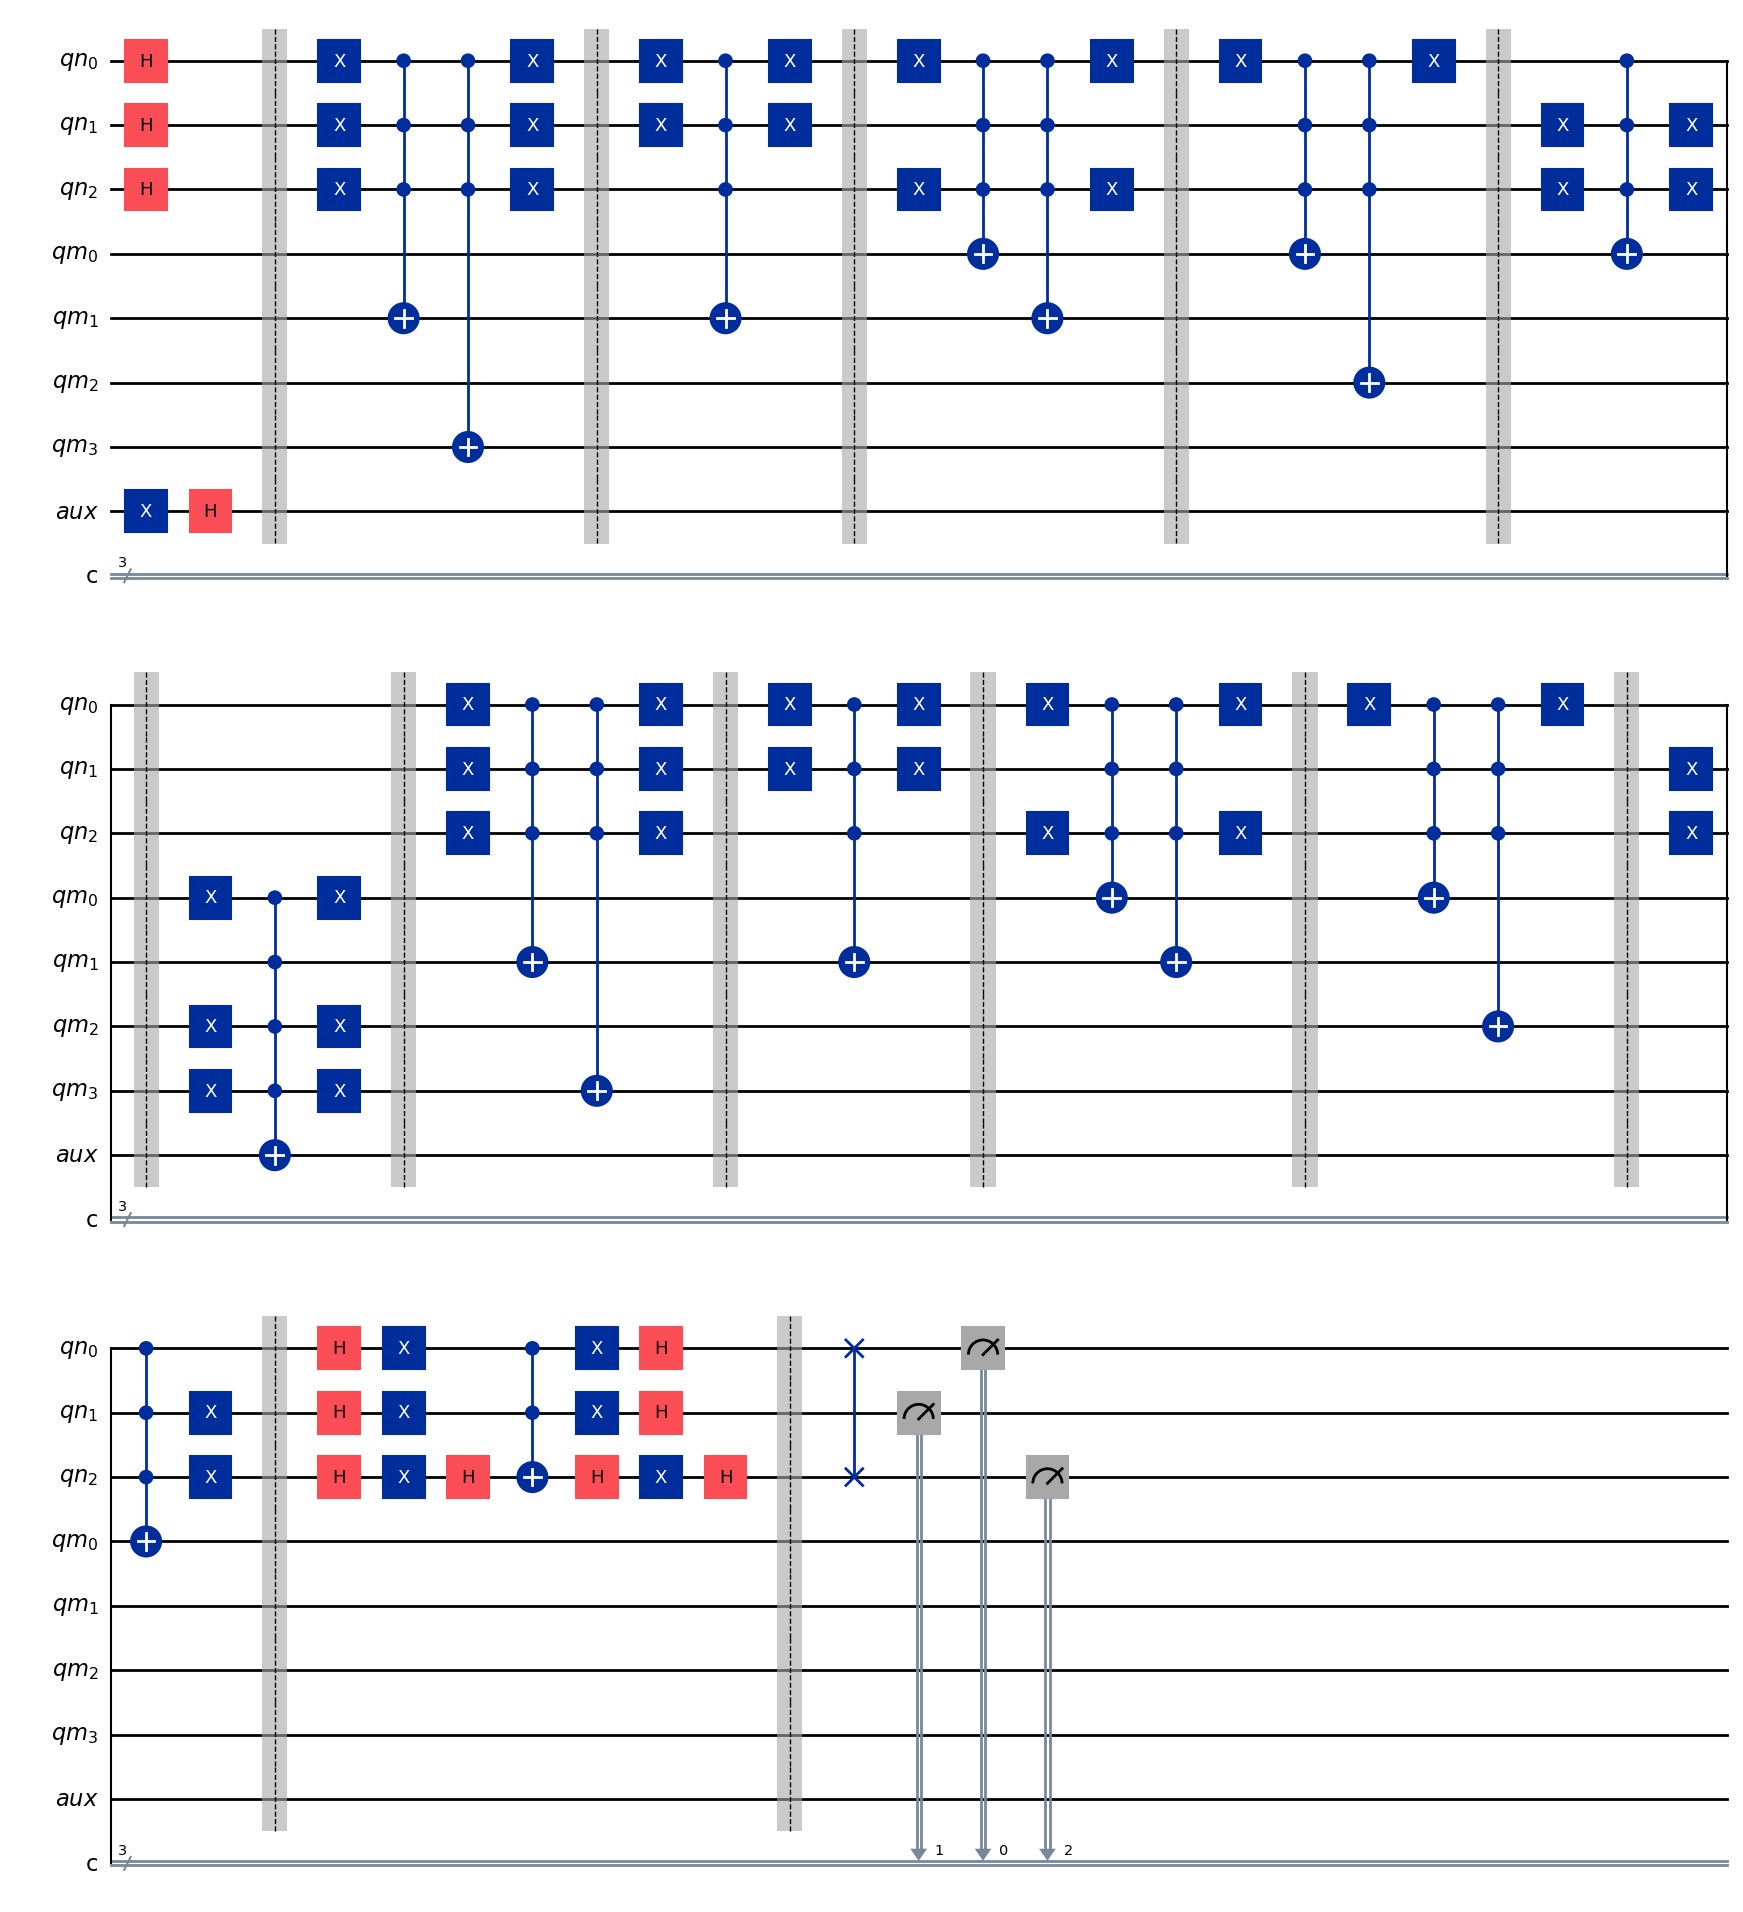

In [14]:
QSM.draw(output = 'mpl')

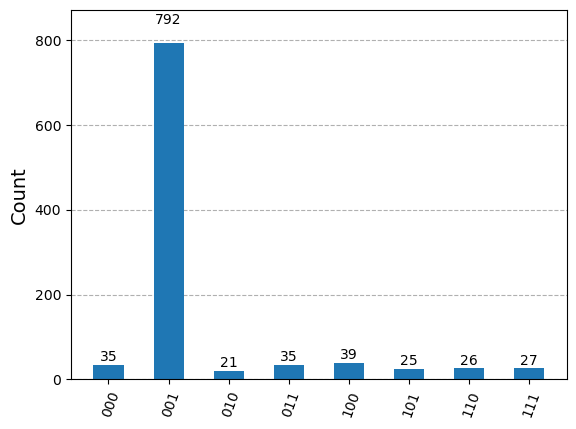

In [15]:
plot_histogram(counts)

And $f(| 001 \rangle) = 4 = y_{min}$, as we wished to show.